In [100]:
from typing import List
import os
import json
import ast
import pandas as pd
import csv
import argparse
import pickle
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
!pip install -q gwpy
!pip install rouge
nltk.download('punkt')
nltk.download('stopwords')
from rouge import Rouge
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read csv files

In [3]:
curr_path = os.getcwd()

# Path to twcs.csv File
twcs = pd.read_csv(curr_path + '/drive/MyDrive/twcs.csv')

In [37]:
twcs.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


### Creating a dictionary for tweet Data


In [67]:
twcs_dict = {}
for i in range(len(twcs)):
    twcs_dict[twcs.iloc[i]['tweet_id']] = [twcs.iloc[i]['author_id'], twcs.iloc[i]['text']]    

### Store the twcs dictionary variable (Optional)
Store twcs_dict variable if you need since it takes a long time to rerun the code.

In [5]:
# Store the dictionary variable 
f_twcs_dict = open('twcs_dict.pckl', 'wb')
pickle.dump(twcs_dict, f_twcs_dict)
f_twcs_dict.close()

In [21]:
# Get twcs_dict data from the following link if you need it 
# https://drive.google.com/file/d/1uX5vS3n5eICIZjvJLSusue8Euw7JuXSM/view?usp=share_link
# f_twcs_dict = open(curr_path + '/drive/MyDrive/twcs_dict.pckl', 'rb')
# twcs_dict = pickle.load(f_twcs_dict)

## Get dialogs with summaries

In [30]:
def get_dialog_with_summaries(TWEETSUM_JSON_FILE_PATH):
  with open(TWEETSUM_JSON_FILE_PATH, 'r') as json_file:
    test_data = [json.loads(line) for line in json_file]

  parsed = []

  for t in test_data:    
      anno = t['annotations']    
      for a in anno:      
          abst = a['abstractive']
          tweets = a['extractive']
          if tweets is not None:
              dialog = []
              for t in tweets:                    
                  dialog.append(twcs_dict[t['tweet_id']][0] + ": " + twcs_dict[t['tweet_id']][1] + "\n")        
              parsed.append(["".join(dialog), " ".join(abst)])

  return parsed

# TWEETSUM_JSON_FILE_PATH = curr_path + "/final_train_tweetsum.jsonl"
# TWEETSUM_JSON_FILE_PATH = curr_path + "/final_valid_tweetsum.jsonl"
TWEETSUM_JSON_FILE_PATH = curr_path + "/final_test_tweetsum.jsonl"

TEST_DATA_parsed = get_dialog_with_summaries(TWEETSUM_JSON_FILE_PATH)

In [31]:
test_parsed = pd.DataFrame(TEST_DATA_parsed, columns=['dialog', 'summary'])

In [32]:
test_parsed.head(1)

,dialog,summary
0,658975: @hulu_support My watchlist is not upda...,Customer is complaining that the watchlist is ...


In [33]:
test_parsed.to_csv('./twcs_test.csv')

### Creating a summarization

In [34]:
def run_summarizer(input):
    output_list = []

    from transformers import pipeline
    summarizer = pipeline("summarization", model="linydub/bart-large-samsum")

    for i in range(len(input)):
        output_list.append(summarizer(input[i]))
    
    return output_list

In [35]:
test_result = run_summarizer(test_parsed['dialog'].tolist())

test_parsed['predicted'] = test_result

test_parsed.to_csv('./twcs_test_predicted.csv')

Your max_length is set to 62, but you input_length is only 60. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 62, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 62, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 62, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 62, but you input_length is only 60. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


In [36]:
# Store the test_result variable
test_result_obj = open('test_parsed.pckl', 'wb')
pickle.dump(test_result, test_result_obj)
f_twcs_dict.close()

### Showing the Predicted result

In [38]:
test_parsed.head(5)

,dialog,summary,predicted
0,658975: @hulu_support My watchlist is not upda...,Customer is complaining that the watchlist is ...,[{'summary_text': 'Norlene's watchlist is not ...
1,658975: @hulu_support My watchlist is not upda...,Customer is complaining that my watch list is ...,[{'summary_text': 'Hulu's watchlist is not upd...
2,658975: @hulu_support My watchlist is not upda...,Customer is complaining that he is not getting...,[{'summary_text': 'Norlene's Hulu watchlist is...
3,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is asking about the ACC to link to th...,[{'summary_text': '637109's Acc was linked to ...
4,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is enquiring that whether they can ch...,[{'summary_text': 'Airbnb help asks 637109 to ...


### Compare Two Summarizations with Cosine Similarity


In [73]:
# Reference https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/
def generation_cosine_similarity(X, Y):  
  # tokenization
  X_list = word_tokenize(X) 
  Y_list = word_tokenize(Y)
    
  # sw contains the list of stopwords
  sw = stopwords.words('english') 
  l1 =[];l2 =[]
    
  # remove stop words from the string
  X_set = {w for w in X_list if not w in sw} 
  Y_set = {w for w in Y_list if not w in sw}
    
  # form a set containing keywords of both strings 
  rvector = X_set.union(Y_set) 
  for w in rvector:
      if w in X_set: l1.append(1) # create a vector
      else: l1.append(0)
      if w in Y_set: l2.append(1)
      else: l2.append(0)
  c = 0
    
  # cosine formula 
  for i in range(len(rvector)):
          c+= l1[i]*l2[i]
  cosine = c / float((sum(l1)*sum(l2))**0.5)
  return cosine
consine_similarity_scores = []

for i in range(len(test_parsed)):
  X = test_parsed['summary'][i]
  Y = test_parsed['predicted'][i][0]['summary_text']
  cosine_sim = generation_cosine_similarity(X,Y)
  consine_similarity_scores.append(cosine_sim)


In [77]:
test_parsed['cosine_similarities'] = consine_similarity_scores

In [82]:
test_parsed.head(5)

,dialog,summary,predicted,cosine_similarities
0,658975: @hulu_support My watchlist is not upda...,Customer is complaining that the watchlist is ...,[{'summary_text': 'Norlene's watchlist is not ...,0.372678
1,658975: @hulu_support My watchlist is not upda...,Customer is complaining that my watch list is ...,[{'summary_text': 'Hulu's watchlist is not upd...,0.416025
2,658975: @hulu_support My watchlist is not upda...,Customer is complaining that he is not getting...,[{'summary_text': 'Norlene's Hulu watchlist is...,0.282843
3,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is asking about the ACC to link to th...,[{'summary_text': '637109's Acc was linked to ...,0.246183
4,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is enquiring that whether they can ch...,[{'summary_text': 'Airbnb help asks 637109 to ...,0.072739


In [90]:
print("Max for cosine_similarities    : ", np.max(test_parsed['cosine_similarities']))
print("Min for cosine_similarities    : ", np.min(test_parsed['cosine_similarities']))
print("Mean for cosine_similarities   : ", np.mean(test_parsed['cosine_similarities']))
print("Median for cosine_similarities : ", np.median(test_parsed['cosine_similarities']))

Max for cosine_similarities    :  0.7735267838285931
Min for cosine_similarities    :  0.051639777949432225
Mean for cosine_similarities   :  0.29148590319586826
Median for cosine_similarities :  0.27386127875258304


<AxesSubplot:title={'center':'Cosine Similarities for two summarizations'}, xlabel='cosine_similarities'>

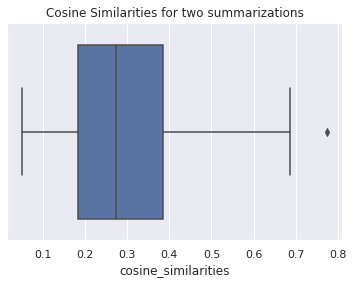

In [96]:
sns.set(style="darkgrid")
plt.title("Cosine Similarities for two summarizations")
sns.boxplot(x=test_parsed["cosine_similarities"])

## Compare Two summarizations with Rouge 1, 2

In [123]:
def generation_Rouge_Scores(X, Y):  
  rouge = Rouge()
  return rouge.get_scores(X, Y)

In [139]:
Rouge_1_scores_list = []
Rouge_2_scores_list = []
for i in range(len(test_parsed)):
  X = test_parsed['summary'][i]
  Y = test_parsed['predicted'][i][0]['summary_text']  
  get_rouge_scores = generation_Rouge_Scores(X,Y)
  Rouge_1_scores = get_rouge_scores[0]['rouge-1']['r']
  Rouge_2_scores = get_rouge_scores[0]['rouge-2']['r']

  Rouge_1_scores_list.append(Rouge_1_scores)
  Rouge_2_scores_list.append(Rouge_2_scores)

In [140]:
test_parsed['Rouge_1_scores'] = Rouge_1_scores_list
test_parsed['Rouge_2_scores'] = Rouge_2_scores_list

In [143]:
print("Max for Rouge_1 scores    : ", np.max(test_parsed['Rouge_1_scores']))
print("Min for Rouge_1 scores    : ", np.min(test_parsed['Rouge_1_scores']))
print("Mean for Rouge_1 scores   : ", np.mean(test_parsed['Rouge_1_scores']))
print("Median for Rouge_1 scores : ", np.median(test_parsed['Rouge_1_scores']))

Max for Rouge_1 scores    :  0.8571428571428571
Min for Rouge_1 scores    :  0.0
Mean for Rouge_1 scores   :  0.35079820042920057
Median for Rouge_1 scores :  0.3333333333333333


<AxesSubplot:title={'center':'Rouge 1 scores for two summarizations'}, xlabel='Rouge_1_scores'>

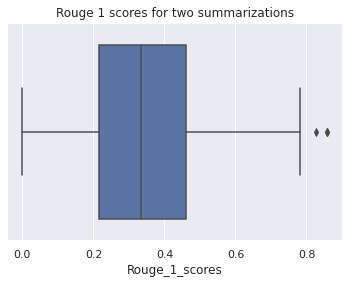

In [144]:
plt.title("Rouge 1 scores for two summarizations")
sns.boxplot(x=test_parsed["Rouge_1_scores"])

In [145]:
print("Max for Rouge_2 scores    : ", np.max(test_parsed['Rouge_2_scores']))
print("Min for Rouge_2 scores    : ", np.min(test_parsed['Rouge_2_scores']))
print("Mean for Rouge_2 scores   : ", np.mean(test_parsed['Rouge_2_scores']))
print("Median for Rouge_2 scores : ", np.median(test_parsed['Rouge_2_scores']))

Max for Rouge_2 scores    :  0.6842105263157895
Min for Rouge_2 scores    :  0.0
Mean for Rouge_2 scores   :  0.14546800689778763
Median for Rouge_2 scores :  0.0967741935483871


<AxesSubplot:title={'center':'Rouge_2 scores for two summarizations'}, xlabel='Rouge_2_scores'>

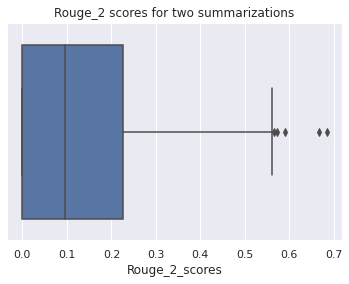

In [146]:
plt.title("Rouge_2 scores for two summarizations")
sns.boxplot(x=test_parsed["Rouge_2_scores"])